### Quick theory
Just like the Actor-Critic method, we have two networks:

* Actor - It proposes an action given a state.
* Critic - It predicts if the action is good (positive value) or bad (negative value) given a state and an action.

DDPG uses two more techniques not present in the original DQN:

1. Uses two Target networks.
        Why? Because it add stability to training. In short, we are learning from estimated targets and Target networks are updated slowly, hence keeping our estimated targets stable.Conceptually, this is like saying, "I have an idea of how to play this well, I'm going to try it out for a bit until I find something better", as opposed to saying "I'm going to re-learn how to play this entire game after every move". See this StackOverflow answer.

2. Uses Experience Replay.

### Losses:

**Critic loss** - Mean Squared Error of y - Q(s, a) where y is the expected return as seen by the Target network, and Q(s, a) is action value predicted by the Critic network. y is a moving target that the critic model tries to achieve; we make this target stable by updating the Target model slowly.

**Actor loss** - This is computed using the mean of the value given by the Critic network for the actions taken by the Actor network. We seek to maximize this quantity.

Hence we update the Actor network so that it produces actions that get the maximum predicted value as seen by the Critic, for a given state.

### Initialization:
The initialization for last layer of the Actor must be between -0.003 and 0.003 as this prevents us from getting 1 or -1 output values in the initial stages, which would squash our gradients to zero, as we use the tanh activation.

In [1]:
import shutup
shutup.please()

In [2]:
import numpy as np

from src.agents.agent import Agent
from src.utils.buffer import Buffer

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Concatenate

import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [3]:
"""
To implement better exploration by the Actor network, we use noisy perturbations, 
specifically an Ornstein-Uhlenbeck process for generating noise, as described in the paper. 
It samples noise from a correlated normal distribution.
"""

import numpy as np

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64, num_actions=1,):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1




In [5]:
import numpy as np

from src.agents.agent import Agent
from src.utils.buffer import Buffer

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate

from src.utils.noise import OUActionNoise 

class Buffer:
    def __init__(self,n_actions, n_states, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, n_states))
        self.action_buffer = np.zeros((self.buffer_capacity, n_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, n_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1


class DdpgAgent(Agent):
    def __init__(self,
                 environment,
                 gamma = 0.99,
                 tau= 0.005,
                 std_dev = 0.2,
                 critic_lr = 0.002,
                 actor_lr = 0.001,
                 buffer_size=50000,
                 batch_size=64,
                 critic_optimizer = tf.keras.optimizers.Adam,
                 actor_optimizer = tf.keras.optimizers.Adam,
        ):
        super(DdpgAgent,self).__init__(environment,args=locals())
        
        self.std_dev = std_dev
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr

        self.noise = OUActionNoise(mean=np.zeros(self.n_actions), std_deviation=float(std_dev) * np.ones(self.n_actions))
        
        self.critic_optimizer = critic_optimizer(critic_lr)
        self.actor_optimizer = actor_optimizer(actor_lr)

        # Discount factor for future rewards
        self.gamma = gamma
        # Used to update target networks
        self.tau = tau

        if self.action_space_mode != "continuous":
            raise Exception('DDPG only accepts continuous action spaces')

        self.__init_networks()
        self.__init_buffers()
        
        self._add_models_to_config([self.actor,self.target_actor,self.critic,self.target_critic])
        self._init_tensorboard()
        
    def __init_buffers(self):
        self.buffer = Buffer(self.n_actions, self.n_inputs, self.buffer_size, self.batch_size)
            
    def __init_networks(self):
        
        def create_actor():
            # Initialize weights between -3e-3 and 3-e3
            last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

            inputs = Input(shape=self.env.observation_space.shape)
            out = Flatten()(inputs)
            out = Dense(256, activation="relu")(out)
            out = Dense(256, activation="relu")(out)
            outputs = Dense(self.n_actions, activation="tanh", kernel_initializer=last_init)(out)

            # Our upper bound is 2.0 for Pendulum.
            outputs = outputs * self.action_upper_bounds
            return tf.keras.Model(inputs, outputs)
        
        def create_critic():
            # State as input
            state_input = Input(shape=self.env.observation_space.shape)
            state_out = Flatten()(state_input)
            state_out = Dense(16, activation="relu")(state_out)
            state_out = Dense(32, activation="relu")(state_out)

            # Action as input
            action_input = Input(shape=(self.n_actions))
            action_out = Dense(32, activation="relu")(action_input)

            # Both are passed through seperate layer before concatenating
            concat = Concatenate()([state_out, action_out])

            out = Dense(256, activation="relu")(concat)
            out = Dense(256, activation="relu")(out)
            outputs = Dense(1)(out)

            # Outputs single value for give state-action
            return tf.keras.Model([state_input, action_input], outputs)
        
        self.actor = create_actor()
        self.target_actor = create_actor()
        
        self.critic = create_critic()
        self.target_critic = create_critic()
        
        self.target_actor.set_weights(self.actor.get_weights())
        self.target_critic.set_weights(self.critic.get_weights())
    
    def choose_action(self,state):
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        sampled_actions = tf.squeeze(self.actor(state))
        noise = self.noise()
        # Adding noise to action
        sampled_actions = sampled_actions.numpy() + noise

        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions, self.action_lower_bounds, self.action_upper_bounds)

        return [np.squeeze(legal_action)]
    
    # This update target parameters slowly
    # Based on rate `tau`, which is much less than one.
    @tf.function
    def update_target(self,target_weights, weights, tau):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * tau + a * (1 - tau))
            
    @tf.function
    def update(self,state_batch, action_batch, reward_batch, next_state_batch):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor(state_batch, training=True)
            critic_value = self.critic([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor.trainable_variables)
        )
            
    def replay(self):

        record_range = min(self.buffer.buffer_counter, self.buffer.buffer_capacity)
        
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.buffer.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.buffer.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.buffer.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.buffer.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.buffer.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        
    def test(self, episodes=10, render=True):

        for episode in range(episodes):
            try:
                state = self.env.reset()
            except:
                self._Agent__init_environment()
                state = self.env.reset()

            done = False
            score = 0
            while not done:
                if render:
                    self.env.render()
                    
                action = self.choose_action(state)

                # Step
                state,reward,done, info = self.env.step(action)

                # Get next state
                score += reward
            
            if render:
                self.env.close()

            print("Test episode: {}, score: {:.2f}".format(episode,score)) 
    
    def learn(self, timesteps=-1, plot_results=True, reset=False, success_threshold=False, log_each_n_episodes=100, log_level=1):
        self.validate_learn(timesteps,success_threshold,reset)
        success_threshold = success_threshold if success_threshold else self.env.success_threshold

        score = 0
        timestep = 0
        episode = 0
        while self.learning_condition(timesteps,timestep):  # Run until solved
            prev_state = self.env.reset()
            score = 0
            done = False
            while not done:
                
                action = self.choose_action(prev_state)
                state, reward, done, info = self.env.step(action)
                self.buffer.record((prev_state, action, reward, state))
                self.replay()
                self.update_target(self.target_actor.variables, self.actor.variables, self.tau)
                self.update_target(self.target_critic.variables, self.critic.variables, self.tau)
                prev_state=state
                score += reward
                timestep+=1
                

            self.running_reward.step(score)
            # Log details
            episode += 1
            self.learning_log.episode(
                log_each_n_episodes,
                score,
                self.running_reward.reward, 
                log_level=log_level
            )
            if self.did_finnish_learning(success_threshold,episode):
                break


        if plot_results:
            self.plot_learning_results()


| ---------------------------------
| Pendulum-v1
| 
| Action space: Continuous with low state-space
| Environment beated threshold: -200
| ----------------------------------------------------------   


Episode * 10 * Moving Avg Reward is ==> -1441.650 * Last Reward was ==> -1504.367
Episode * 20 * Moving Avg Reward is ==> -1033.309 * Last Reward was ==> -1023.961
Episode * 30 * Moving Avg Reward is ==> -793.685 * Last Reward was ==> -119.888
Episode * 40 * Moving Avg Reward is ==> -666.652 * Last Reward was ==> -124.972
Episode * 50 * Moving Avg Reward is ==> -568.292 * Last Reward was ==> -136.304
Episode * 60 * Moving Avg Reward is ==> -344.766 * Last Reward was ==> -361.740
Episode * 70 * Moving Avg Reward is ==> -261.202 * Last Reward was ==> -124.883
Episode * 80 * Moving Avg Reward is ==> -247.342 * Last Reward was ==> -344.919
Episode * 90 * Moving Avg Reward is ==> -231.940 * Last Reward was ==> -248.509
Episode * 100 * Moving Avg Reward is ==> -225.026 * Last Reward was ==>

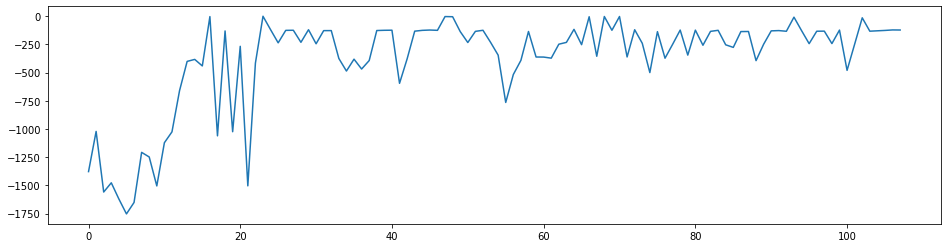

In [6]:
from src.environments.continuous.pendulum import environment
agent = DdpgAgent(environment)
agent.learn(log_each_n_episodes=10)

In [7]:
#agent.test()